<a href="https://colab.research.google.com/github/Anu-cs/Fruit-Net_disease_classifier/blob/main/fruit_diseases_detection_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
import shutil
import os
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2, ResNet50, EfficientNetB0
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
train_folder="/content/drive/MyDrive/Citrus/Pomegranate diseases dataset/training"
test_folder= "/content/drive/MyDrive/Citrus/Pomegranate diseases dataset/testing"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define image size and batch size
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 8
# batch 8

In [ ]:
from itertools import chain

# Define Image Data Generators
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load data using generators
train_dataset = train_datagen.flow_from_directory(
    train_folder,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

# val_dataset = train_datagen.flow_from_directory(
#     val_folder,
#     target_size=IMAGE_SIZE,
#     batch_size=BATCH_SIZE,
#     class_mode='categorical',
#     shuffle=True
# )
# test_folder = '/content/drive/MyDrive/Citrus/dataset/testing_data'
test_datagen = ImageDataGenerator(rescale=1./255)
test_dataset = test_datagen.flow_from_directory(
    test_folder,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)
# test_dataset = chain(test_dataset, val_dataset)

Found 5625 images belonging to 5 classes.
Found 1875 images belonging to 5 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2, ResNet50, EfficientNetB0
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
# Input shape and batch size settings
input_shape = (224, 224, 3)
from tensorflow.keras.layers import Layer, Conv2D, Activation, Multiply, Add, Permute

# Self-Attention Layer
class SelfAttention(Layer):
    def __init__(self, filters, **kwargs):
        super(SelfAttention, self).__init__(**kwargs)
        self.filters = filters  # Store filters as an instance attribute
        self.conv1 = Conv2D(filters // 8, kernel_size=1, strides=1, padding='same')
        self.conv2 = Conv2D(filters // 8, kernel_size=1, strides=1, padding='same')
        self.conv3 = Conv2D(filters, kernel_size=1, strides=1, padding='same')
        self.softmax = Activation('softmax')

    def call(self, inputs):
        # Generate query, key, and value matrices
        query = self.conv1(inputs)
        key = self.conv2(inputs)
        value = self.conv3(inputs)

        # Compute attention map
        attention = tf.matmul(tf.reshape(query, [tf.shape(query)[0], -1, tf.shape(query)[-1]]),
                              tf.reshape(key, [tf.shape(key)[0], -1, tf.shape(key)[-1]]), transpose_b=True)
        attention = self.softmax(attention)

        # Apply attention to value
        attention_output = tf.matmul(attention, tf.reshape(value, [tf.shape(value)[0], -1, tf.shape(value)[-1]]))
        attention_output = tf.reshape(attention_output, tf.shape(inputs))

        # Combine input with attention output
        return Add()([inputs, attention_output])
    def get_config(self):
        config = super(SelfAttention, self).get_config()
        config.update({"filters": self.filters})
        return config

from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Reshape
# Channel Attention Layer
class ChannelAttention(Layer):
    def __init__(self, filters, reduction=16, **kwargs):
        super(ChannelAttention, self).__init__(**kwargs)  # Correct super call
        self.filters = filters
        self.reduction = reduction  # Store reduction as an instance attribute
        self.global_avg_pool = GlobalAveragePooling2D()
        self.dense1 = Dense(filters // reduction, activation='relu', use_bias=False)
        self.dense2 = Dense(filters, activation='sigmoid', use_bias=False)
        self.reshape = Reshape((1, 1, filters))

    def call(self, inputs):
        # Squeeze and excitation
        avg_pooled = self.global_avg_pool(inputs)
        attention = self.dense1(avg_pooled)
        attention = self.dense2(attention)
        attention = self.reshape(attention)
        return Multiply()([inputs, attention])

    def get_config(self):
        config = super(ChannelAttention, self).get_config()
        config.update({
            "filters": self.filters,
            "reduction": self.reduction
        })
        return config
from tensorflow.keras.layers import Concatenate
# Spatial Attention Layer
class SpatialAttention(Layer):
    def __init__(self, **kwargs):
        super(SpatialAttention, self).__init__(**kwargs)
        self.conv = Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')

    def call(self, inputs):
        avg_pool = tf.reduce_mean(inputs, axis=-1, keepdims=True)
        max_pool = tf.reduce_max(inputs, axis=-1, keepdims=True)
        concat = Concatenate(axis=-1)([avg_pool, max_pool])
        return Multiply()([inputs, self.conv(concat)])
    def get_config(self):
        config = super(SpatialAttention, self).get_config()
        return config


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers


In [ ]:
def create_base_model_with_l1(model_fn, input_shape, name):
    inputs = Input(shape=input_shape)
    base_model = model_fn(include_top=False, weights='imagenet', input_tensor=inputs)
    # x = base_model.output
    # x = GlobalAveragePooling2D()(x)

    # # First Dense layer with L1 regularization
    # x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.01))(x)
    # x = Dropout(0.2)(x)  # Dropout layer with rate 0.3

    # # Output layer with Sigmoid activation for binary classification
    # outputs = Dense(5, activation='softmax')(x)
    model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(224, kernel_regularizer= regularizers.l2(0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(5, activation= 'softmax')
    ])
    #model = Model(inputs=inputs, outputs=outputs, name=name)
    # model.compile(
    #     optimizer='adam',  # Adam optimizer
    #     loss='categorical_crossentropy',  # Binary classification loss
    #     metrics=['accuracy']  # Include custom F1 score
    # )
    model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

    return model

def create_base_model_with_l1_self(model_fn, input_shape, name):
    inputs = Input(shape=input_shape)
    base_model = model_fn(include_top=False, weights='imagenet', input_tensor=inputs)
    # x = base_model.output
    # x = SelfAttention(filters=base_model.output.shape[-1])(x)
    # x = GlobalAveragePooling2D()(x)

    # # First Dense layer with L1 regularization
    # x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.01))(x)
    # x = Dropout(0.2)(x)  # Dropout layer with rate 0.3

    # # Output layer with Sigmoid activation for binary classification
    # outputs = Dense(5, activation='softmax')(x)

    # model = Model(inputs=inputs, outputs=outputs, name=name)
    model = Sequential([
    base_model,
    SelfAttention(filters=base_model.output.shape[-1]),
    GlobalAveragePooling2D(),
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(224, kernel_regularizer= regularizers.l2(0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(5, activation= 'softmax')
    ])
    # model.compile(
    #     optimizer='adam',  # Adam optimizer
    #     loss='categorical_crossentropy',  # Binary classification loss
    #     metrics=['accuracy']  # Include custom F1 score
    # )
    model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

    return model

def create_base_model_with_l1_spatial(model_fn, input_shape, name):
    inputs = Input(shape=input_shape)
    base_model = model_fn(include_top=False, weights='imagenet', input_tensor=inputs)
    # x = base_model.output
    # x = SpatialAttention()(x)
    # x = GlobalAveragePooling2D()(x)

    # # First Dense layer with L1 regularization
    # x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.01))(x)
    # x = Dropout(0.2)(x)  # Dropout layer with rate 0.3

    # # Output layer with Sigmoid activation for binary classification
    # outputs = Dense(5, activation='softmax')(x)

    # model = Model(inputs=inputs, outputs=outputs, name=name)
    model = Sequential([
    base_model,
    SpatialAttention(),
    GlobalAveragePooling2D(),
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(224, kernel_regularizer= regularizers.l2(0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(5, activation= 'softmax')
    ])
    # model.compile(
    #     optimizer='adam',  # Adam optimizer
    #     loss='categorical_crossentropy',  # Binary classification loss
    #     metrics=['accuracy']  # Include custom F1 score
    # )
    model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

    return model

def create_base_model_with_l1_channal(model_fn, input_shape, name):
    inputs = Input(shape=input_shape)
    base_model = model_fn(include_top=False, weights="imagenet", input_tensor=inputs)
    # x = base_model.output
    # x = ChannelAttention(filters=base_model.output.shape[-1])(x)
    # x = GlobalAveragePooling2D()(x)

    # # First Dense layer with L1 regularization
    # x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.01))(x)
    # x = Dropout(0.2)(x)  # Dropout layer with rate 0.3

    # # Output layer with Sigmoid activation for binary classification
    # outputs = Dense(5, activation='softmax')(x)

    # model = Model(inputs=inputs, outputs=outputs, name=name)
    model = Sequential([
    base_model,
    ChannelAttention(filters=base_model.output.shape[-1]),
    GlobalAveragePooling2D(),
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(224, kernel_regularizer= regularizers.l2(0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(5, activation= 'softmax')
    ])

    # model.compile(
    #     optimizer='adam',  # Adam optimizer
    #     loss='categorical_crossentropy',  # Binary classification loss
    #     metrics=['accuracy']  # Include custom F1 score
    # )
    model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

    return model

In [ ]:
def create_base_resnet_model_with_l1(model_fn, input_shape, name):
    inputs = Input(shape=input_shape)
    base_model = model_fn(include_top=False, weights='imagenet', input_tensor=inputs)
    # x = base_model.output
    # x = GlobalAveragePooling2D()(x)

    # # First Dense layer with L1 regularization
    # x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.01))(x)
    # x = Dropout(0.2)(x)  # Dropout layer with rate 0.3

    # # Output layer with Sigmoid activation for binary classification
    # outputs = Dense(5, activation='softmax')(x)
    model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(224, kernel_regularizer= regularizers.l2(0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(5, activation= 'softmax')
    ])
    #model = Model(inputs=inputs, outputs=outputs, name=name)
    # model.compile(
    #     optimizer='adam',  # Adam optimizer
    #     loss='categorical_crossentropy',  # Binary classification loss
    #     metrics=['accuracy']  # Include custom F1 score
    # )
    model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

    return model


In [ ]:
# Function to load model from a checkpoint
def load_model_from_checkpoint(model, model_name):
    try:
        model.load_weights(f'./{model_name}_best_weights.weights.h5')
        print(f'{model_name} loaded from checkpoint.')
    except Exception as e:
        print(f'No checkpoint found for {model_name}, starting training from scratch.')

In [ ]:
# Create early stopping callback based on F1 score
def create_early_stopping_callback(target_f1=0.99):
    return EarlyStopping(
        monitor='val_accuracy',
        min_delta=0.001,
        patience=10,  # Set patience to wait for improvement
        verbose=1,
        mode='max',  # We want to maximize the F1 score
        baseline=target_f1  # The target F1 score baseline
    )

In [ ]:
# Create checkpoint callback to save the best model based on accuracy
def create_checkpoint_callback(model_name):
    return ModelCheckpoint(
        filepath=f'./{model_name}_best_weights.weights.h5',
        monitor='accuracy',  # Monitor the accuracy metric
        save_best_only=True,
        save_weights_only=True,
        verbose=1,
        mode='max'
    )

In [ ]:
# Create models
mobilenet_model = create_base_model_with_l1(MobileNetV2, input_shape, 'MobileNetV2')
mobilenet_self_model = create_base_model_with_l1_self(MobileNetV2, input_shape, 'MobileNetV2')
mobilenet_spatial_model = create_base_model_with_l1_spatial(MobileNetV2, input_shape, 'MobileNetV2')
mobilenet_channal_model = create_base_model_with_l1_channal(MobileNetV2, input_shape, 'MobileNetV2')

resnet_self_model = create_base_model_with_l1_self(ResNet50, input_shape, 'ResNet50')
resnet_spatial_model = create_base_model_with_l1_spatial(ResNet50, input_shape, 'ResNet50')
resnet_channal_model = create_base_model_with_l1_channal(ResNet50, input_shape, 'ResNet50')

efficientnet_model = create_base_model_with_l1(EfficientNetB0, input_shape, 'EfficientNetB0')
# efficientnet_self_model = create_base_model_with_l1_self(EfficientNetB0, input_shape, 'EfficientNetB0')
# efficientnet_spatial_model = create_base_model_with_l1_spatial(EfficientNetB0, input_shape, 'EfficientNetB0')
# efficientnet_channal_model = create_base_model_with_l1_channal(EfficientNetB0, input_shape, 'EfficientNetB0')

<ipython-input-9-e8ff6959efe1>:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = model_fn(include_top=False, weights='imagenet', input_tensor=inputs)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


<ipython-input-9-e8ff6959efe1>:34: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = model_fn(include_top=False, weights='imagenet', input_tensor=inputs)
<ipython-input-9-e8ff6959efe1>:68: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = model_fn(include_top=False, weights='imagenet', input_tensor=inputs)
<ipython-input-9-e8ff6959efe1>:102: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = model_fn(include_top=False, weights="imagenet", input_tensor=inputs)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
resnet_model = create_base_resnet_model_with_l1(ResNet50, input_shape, 'ResNet50')


In [ ]:
# Training procedure for each model
def train_model(model, model_name, train_dataset):
    load_model_from_checkpoint(model, model_name)
    print(f'Training {model_name}...')
    history = model.fit(
        train_dataset,
        epochs=20,
        # validation_data=val_dataset,
        callbacks=[
            create_early_stopping_callback(0.99),
            create_checkpoint_callback(model_name)
        ]
    )
    return history

In [ ]:
mobilenet_history = train_model(mobilenet_model, 'MobileNetV2', train_dataset)
mobilenet_model.save('/content/drive/MyDrive/Citrus/Pomegranate diseases dataset/mobilenet_model.h5')


No checkpoint found for MobileNetV2, starting training from scratch.
Training MobileNetV2...
Epoch 1/20


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Extract accuracy and loss values from the history object
accuracy = mobilenet_history.history['accuracy']
loss = mobilenet_history.history['loss']
epochs = range(1, len(accuracy) + 1)

# Plot the training accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, 'bo-', label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot the training loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


NameError: name 'mobilenet_history' is not defined

In [ ]:
mobilenet_self_history = train_model(mobilenet_self_model, 'MobileNetV2', train_dataset)
mobilenet_self_model.save('/content/drive/MyDrive/Citrus/Pomegranate diseases dataset/mobilenet_self_model.h5')


No checkpoint found for MobileNetV2, starting training from scratch.
Training MobileNetV2...
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


703/704 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - accuracy: 0.7841 - loss: 7.7593
Epoch 1: accuracy improved from -inf to 0.84782, saving model to ./MobileNetV2_best_weights.weights.h5


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


704/704 ━━━━━━━━━━━━━━━━━━━━ 1832s 3s/step - accuracy: 0.7843 - loss: 7.7543
Epoch 2/20
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 527ms/step - accuracy: 0.9131 - loss: 3.5172
Epoch 2: accuracy improved from 0.84782 to 0.91609, saving model to ./MobileNetV2_best_weights.weights.h5
704/704 ━━━━━━━━━━━━━━━━━━━━ 386s 527ms/step - accuracy: 0.9131 - loss: 3.5158
Epoch 3/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 526ms/step - accuracy: 0.9480 - loss: 1.8990
Epoch 3: accuracy improved from 0.91609 to 0.94578, saving model to ./MobileNetV2_best_weights.weights.h5
704/704 ━━━━━━━━━━━━━━━━━━━━ 375s 527ms/step - accuracy: 0.9480 - loss: 1.8987
Epoch 4/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - accuracy: 0.9570 - loss: 1.1251
Epoch 4: accuracy improved from 0.94578 to 0.95538, saving model to ./MobileNetV2_best_weights.weights.h5
704/704 ━━━━━━━━━━━━━━━━━━━━ 384s 532ms/step - accuracy: 0.9570 - loss: 1.1250
Epoch 5/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 560ms/step - accuracy: 0.9703 - loss: 0.8102
Epoch 5: accurac

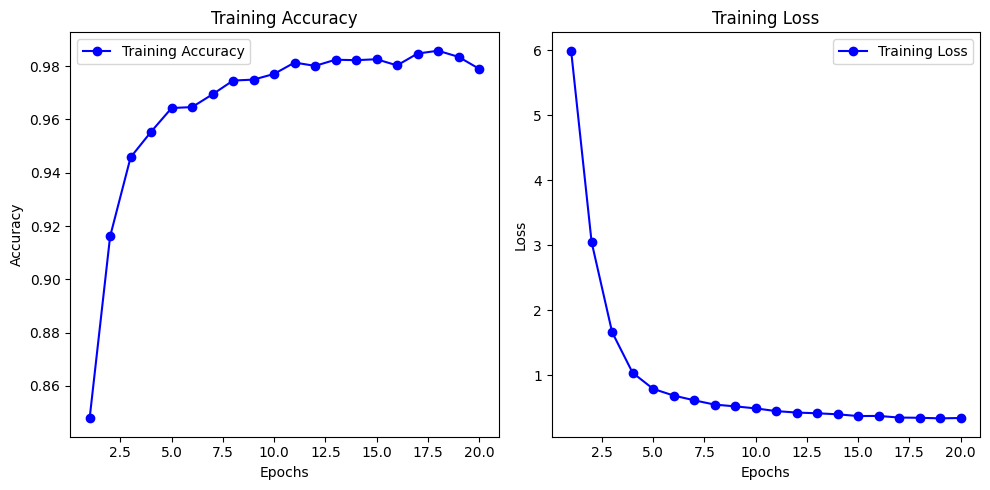

In [ ]:
# Extract accuracy and loss values from the history object
accuracy = mobilenet_self_history.history['accuracy']
loss = mobilenet_self_history.history['loss']
epochs = range(1, len(accuracy) + 1)

# Plot the training accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, 'bo-', label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot the training loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
mobilenet_spatial_history = train_model(mobilenet_spatial_model, 'MobileNetV2', train_dataset)
mobilenet_spatial_model.save('/content/drive/MyDrive/Citrus/Pomegranate diseases dataset/mobilenet_spatial_model.h5')


No checkpoint found for MobileNetV2, starting training from scratch.
Training MobileNetV2...
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8300 - loss: 8.0766
Epoch 1: accuracy improved from -inf to 0.89404, saving model to ./MobileNetV2_best_weights.weights.h5


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


704/704 ━━━━━━━━━━━━━━━━━━━━ 2732s 4s/step - accuracy: 0.8301 - loss: 8.0736
Epoch 2/20
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 547ms/step - accuracy: 0.9512 - loss: 3.0437
Epoch 2: accuracy improved from 0.89404 to 0.95484, saving model to ./MobileNetV2_best_weights.weights.h5
704/704 ━━━━━━━━━━━━━━━━━━━━ 389s 547ms/step - accuracy: 0.9512 - loss: 3.0423
Epoch 3/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 554ms/step - accuracy: 0.9588 - loss: 1.4444
Epoch 3: accuracy improved from 0.95484 to 0.95876, saving model to ./MobileNetV2_best_weights.weights.h5
704/704 ━━━━━━━━━━━━━━━━━━━━ 395s 555ms/step - accuracy: 0.9588 - loss: 1.4442
Epoch 4/20
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 532ms/step - accuracy: 0.9681 - loss: 0.8923
Epoch 4: accuracy improved from 0.95876 to 0.96498, saving model to ./MobileNetV2_best_weights.weights.h5
704/704 ━━━━━━━━━━━━━━━━━━━━ 427s 532ms/step - accuracy: 0.9680 - loss: 0.8922
Epoch 5/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 546ms/step - accuracy: 0.9747 - loss: 0.6934
Epoch 5: accurac

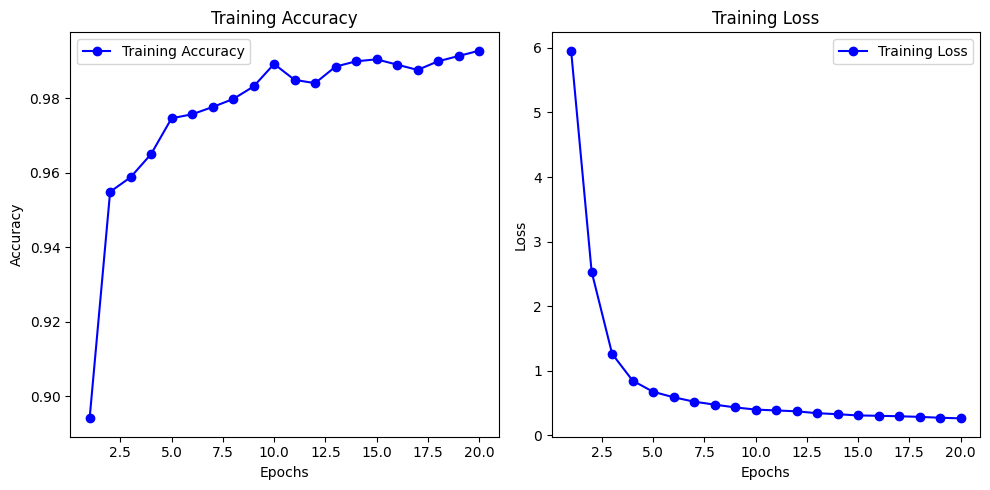

In [ ]:
# Extract accuracy and loss values from the history object
accuracy = mobilenet_spatial_history.history['accuracy']
loss = mobilenet_spatial_history.history['loss']
epochs = range(1, len(accuracy) + 1)

# Plot the training accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, 'bo-', label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot the training loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
mobilenet_channal_history = train_model(mobilenet_channal_model, 'MobileNetV2', train_dataset)
mobilenet_channal_model.save('/content/drive/MyDrive/Citrus/Pomegranate diseases dataset/mobilenet_channal_model.h5')

In [ ]:
# Extract accuracy and loss values from the history object
accuracy = mobilenet_channal_history.history['accuracy']
loss = mobilenet_channal_history.history['loss']
epochs = range(1, len(accuracy) + 1)

# Plot the training accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, 'bo-', label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot the training loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
resnet_history = train_model(resnet_model, 'ResNet50', train_dataset)
resnet_model.save('/content/drive/MyDrive/Citrus/Pomegranate diseases dataset/resnet_model.h5')



No checkpoint found for ResNet50, starting training from scratch.
Training ResNet50...
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8027 - loss: 7.9847
Epoch 1: accuracy improved from -inf to 0.86418, saving model to ./ResNet50_best_weights.weights.h5


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


704/704 ━━━━━━━━━━━━━━━━━━━━ 2376s 3s/step - accuracy: 0.8028 - loss: 7.9821
Epoch 2/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 542ms/step - accuracy: 0.9182 - loss: 3.6508
Epoch 2: accuracy improved from 0.86418 to 0.91538, saving model to ./ResNet50_best_weights.weights.h5
704/704 ━━━━━━━━━━━━━━━━━━━━ 387s 544ms/step - accuracy: 0.9182 - loss: 3.6501
Epoch 3/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 568ms/step - accuracy: 0.9209 - loss: 2.0668
Epoch 3: accuracy improved from 0.91538 to 0.92427, saving model to ./ResNet50_best_weights.weights.h5
704/704 ━━━━━━━━━━━━━━━━━━━━ 406s 569ms/step - accuracy: 0.9209 - loss: 2.0665
Epoch 4/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 545ms/step - accuracy: 0.9483 - loss: 1.2782
Epoch 4: accuracy improved from 0.92427 to 0.95236, saving model to ./ResNet50_best_weights.weights.h5
704/704 ━━━━━━━━━━━━━━━━━━━━ 389s 546ms/step - accuracy: 0.9483 - loss: 1.2780
Epoch 5/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 563ms/step - accuracy: 0.9575 - loss: 0.9306
Epoch 5: accuracy did not

In [ ]:
# Extract accuracy and loss values from the history object
accuracy = resnet_history.history['accuracy']
loss = resnet_history.history['loss']
epochs = range(1, len(accuracy) + 1)

# Plot the training accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, 'bo-', label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot the training loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
resnet_self_history = train_model(resnet_self_model, 'ResNet50', train_dataset)
resnet_self_model.save('/content/drive/MyDrive/Citrus/Pomegranate diseases dataset/resnet_self_model.h5')


In [ ]:
# Extract accuracy and loss values from the history object
accuracy = resnet_self_history.history['accuracy']
loss = resnet_self_history.history['loss']
epochs = range(1, len(accuracy) + 1)

# Plot the training accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, 'bo-', label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot the training loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
resnet_spatial_history = train_model(resnet_spatial_model, 'ResNet50', train_dataset)
resnet_spatial_model.save('/content/drive/MyDrive/Citrus/Pomegranate diseases dataset/resnet_spatial_model.h5')


In [ ]:
# Extract accuracy and loss values from the history object
accuracy = resnet_spatial_history.history['accuracy']
loss = resnet_spatial_history.history['loss']
epochs = range(1, len(accuracy) + 1)

# Plot the training accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, 'bo-', label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot the training loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
resnet_channal_history = train_model(resnet_channal_model, 'ResNet50', train_dataset)
resnet_channal_model.save('/content/drive/MyDrive/Citrus/Pomegranate diseases dataset/resnet_channal_model.h5')


No checkpoint found for ResNet50, starting training from scratch.
Training ResNet50...
Epoch 1/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 611ms/step - accuracy: 0.7811 - loss: 7.6434
Epoch 1: accuracy improved from -inf to 0.86187, saving model to ./ResNet50_best_weights.weights.h5
704/704 ━━━━━━━━━━━━━━━━━━━━ 503s 614ms/step - accuracy: 0.7812 - loss: 7.6409
Epoch 2/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 551ms/step - accuracy: 0.9325 - loss: 3.1981
Epoch 2: accuracy improved from 0.86187 to 0.93636, saving model to ./ResNet50_best_weights.weights.h5
704/704 ━━━━━━━━━━━━━━━━━━━━ 393s 552ms/step - accuracy: 0.9325 - loss: 3.1974
Epoch 3/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 590ms/step - accuracy: 0.9588 - loss: 1.5686
Epoch 3: accuracy improved from 0.93636 to 0.95787, saving model to ./ResNet50_best_weights.weights.h5
704/704 ━━━━━━━━━━━━━━━━━━━━ 422s 592ms/step - accuracy: 0.9588 - loss: 1.5684
Epoch 4/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 526ms/step - accuracy: 0.9600 - loss: 0.9897
Epoch 4: accuracy 

In [ ]:
# Extract accuracy and loss values from the history object
accuracy = resnet_channal_history.history['accuracy']
loss = resnet_channal_history.history['loss']
epochs = range(1, len(accuracy) + 1)

# Plot the training accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, 'bo-', label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot the training loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
efficientnet_history = train_model(efficientnet_model, 'EfficientNetB0', train_dataset)
efficientnet_model.save('/content/drive/MyDrive/Citrus/Pomegranate diseases dataset/efficientnet_model.h5')
# efficientnet_self_history = train_model(efficientnet_self_model, 'EfficientNetB0', train_dataset)
# efficientnet_spatial_history = train_model(efficientnet_spatial_model, 'EfficientNetB0', train_dataset)
# efficientnet_channal_history = train_model(efficientnet_channal_model, 'EfficientNetB0', train_dataset)

No checkpoint found for EfficientNetB0, starting training from scratch.
Training EfficientNetB0...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1202']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7763 - loss: 7.9042
Epoch 1: accuracy improved from -inf to 0.84604, saving model to ./EfficientNetB0_best_weights.weights.h5


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


704/704 ━━━━━━━━━━━━━━━━━━━━ 3542s 5s/step - accuracy: 0.7764 - loss: 7.9016
Epoch 2/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - accuracy: 0.9267 - loss: 3.4033
Epoch 2: accuracy improved from 0.84604 to 0.93529, saving model to ./EfficientNetB0_best_weights.weights.h5
704/704 ━━━━━━━━━━━━━━━━━━━━ 348s 487ms/step - accuracy: 0.9267 - loss: 3.4026
Epoch 3/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step - accuracy: 0.9536 - loss: 1.8100
Epoch 3: accuracy improved from 0.93529 to 0.95396, saving model to ./EfficientNetB0_best_weights.weights.h5
704/704 ━━━━━━━━━━━━━━━━━━━━ 342s 486ms/step - accuracy: 0.9536 - loss: 1.8097
Epoch 4/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step - accuracy: 0.9652 - loss: 1.1009
Epoch 4: accuracy improved from 0.95396 to 0.96853, saving model to ./EfficientNetB0_best_weights.weights.h5
704/704 ━━━━━━━━━━━━━━━━━━━━ 347s 493ms/step - accuracy: 0.9652 - loss: 1.1008
Epoch 5/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step - accuracy: 0.9794 - loss: 0.7779
Epoch 5

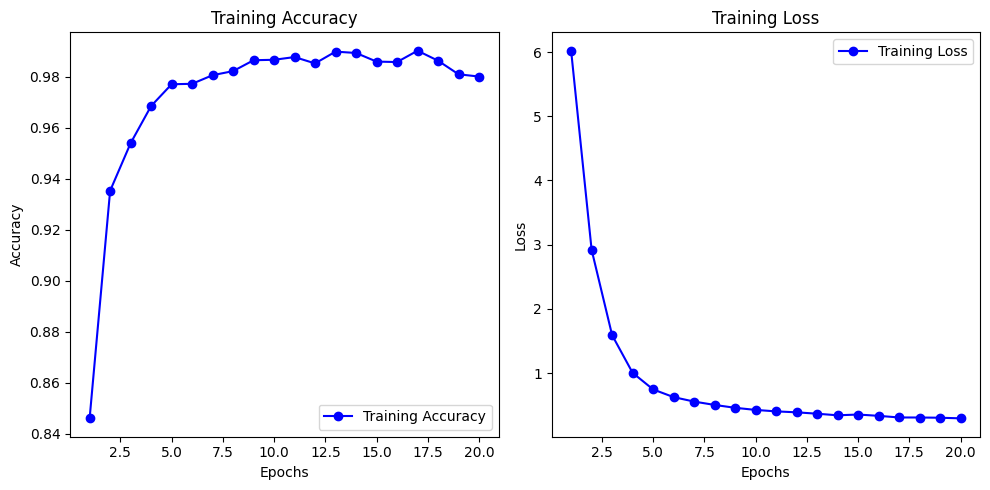

In [ ]:
# Extract accuracy and loss values from the history object
accuracy = efficientnet_history.history['accuracy']
loss = efficientnet_history.history['loss']
epochs = range(1, len(accuracy) + 1)

# Plot the training accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, 'bo-', label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot the training loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# efficientnet_self_model.save('/content/drive/MyDrive/Citrus/efficientnet_self_model.h5')
# efficientnet_spatial_model.save('/content/drive/MyDrive/Citrus/efficientnet_spatial_model.h5')
# efficientnet_channal_model.save('/content/drive/MyDrive/Citrus/efficientnet_channal_model.h5')

**Plot matrices**


In [ ]:
histories = {
    'ResNet50': resnet_history,
    'ResNet50_self': resnet_self_history,
    'ResNet50_spatial': resnet_spatial_history,
    'ResNet50_channal': resnet_channal_history,

    # 'EfficientNetB0': efficientnet_history,
    # 'EfficientNetB0_self': efficientnet_self_history,
    # 'EfficientNetB0_spatial': efficientnet_spatial_history,
    # 'EfficientNetB0_channal': efficientnet_channal_history,

    'MobileNetV2': mobilenet_history,
    'MobileNetV2_self': mobilenet_self_history,
    'MobileNetV2_spatial': mobilenet_spatial_history,
    'MobileNetV2_channal': mobilenet_channal_history
}

In [ ]:
def plot_metrics(histories, key):
    plt.figure(figsize=(8, 6))

    for name, history in histories.items():
        # Find the metric key by checking for any key that starts with 'precision' or 'recall'
        metric_keys = [k for k in history.history.keys() if k.startswith(key)]

        for metric_key in metric_keys:
            plt.plot(history.history[metric_key], label=f'{name} - {metric_key}')

    plt.xlabel('Epochs')
    plt.ylabel(key.capitalize())
    plt.title(f'{key.capitalize()} over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# Plot accuracy
plot_metrics(histories, key='accuracy')

In [ ]:
plot_metrics(histories, key='loss')

**Test Pipeline**

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, MultiHeadAttention
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_score, recall_score, f1_score


In [ ]:
# model = load_model('my_model.h5')
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import custom_object_scope

# efficientnet_model= load_model('/content/drive/MyDrive/Citrus/efficientnet_model.h5')
resnet_model= load_model('/content/drive/MyDrive/Citrus/Pomegranate diseases dataset/resnet_model.h5')
mobilenet_model=load_model('/content/drive/MyDrive/Citrus/Pomegranate diseases dataset/mobilenet_model.h5')
efficientnet_model= load_model('/content/drive/MyDrive/Citrus/Pomegranate diseases dataset/efficientnet_model.h5')

# Register custom layers
custom_objects = {
    "SelfAttention": SelfAttention,
    "ChannelAttention": ChannelAttention,
    "SpatialAttention": SpatialAttention
}

# Load models with custom layers
with custom_object_scope(custom_objects):
    resnet_self_model = load_model('/content/drive/MyDrive/Citrus/Pomegranate diseases dataset/resnet_self_model.h5')
    resnet_spatial_model = load_model('/content/drive/MyDrive/Citrus/Pomegranate diseases dataset/resnet_spatial_model.h5')
    resnet_channal_model = load_model('/content/drive/MyDrive/Citrus/Pomegranate diseases dataset/resnet_channal_model.h5')

    mobilenet_self_model=load_model('/content/drive/MyDrive/Citrus/Pomegranate diseases dataset/mobilenet_self_model.h5')
    mobilenet_spatial_model=load_model('/content/drive/MyDrive/Citrus/Pomegranate diseases dataset/mobilenet_spatial_model.h5')
    mobilenet_channal_model=load_model('/content/drive/MyDrive/Citrus/Pomegranate diseases dataset/mobilenet_channal_model.h5')

    # efficientnet_self_model= load_model('/content/drive/MyDrive/Citrus/efficientnet_self_model.h5')
    # efficientnet_spatial_model= load_model('/content/drive/MyDrive/Citrus/efficientnet_spatial_model.h5')
    # efficientnet_channal_model= load_model('/content/drive/MyDrive/Citrus/efficientnet_channal_model.h5')


# efficientnet_model= load_model('/content/drive/MyDrive/Citrus/efficientnet_model.h5')
# efficientnet_self_model= load_model('/content/drive/MyDrive/Citrus/efficientnet_self_model.h5')
# efficientnet_spatial_model= load_model('/content/drive/MyDrive/Citrus/efficientnet_spatial_model.h5')
# efficientnet_channal_model= load_model('/content/drive/MyDrive/Citrus/efficientnet_channal_model.h5')

# resnet_model= load_model('/content/drive/MyDrive/Citrus/resnet_model.h5')
# resnet_self_model= load_model('/content/drive/MyDrive/Citrus/resnet_self_model.h5')
# resnet_spatial_model= load_model('/content/drive/MyDrive/Citrus/resnet_spatial_model.h5')
# resnet_channal_model= load_model('/content/drive/MyDrive/Citrus/resnet_channal_model.h5')

# mobilenet_model=load_model('/content/drive/MyDrive/Citrus/mobilenet_model.h5')
# mobilenet_self_model=load_model('/content/drive/MyDrive/Citrus/mobilenet_self_model.h5')
# mobilenet_spatial_model=load_model('/content/drive/MyDrive/Citrus/mobilenet_spatial_model.h5')
# mobilenet_channal_model=load_model('/content/drive/MyDrive/Citrus/mobilenet_channal_model.h5')

In [ ]:
def calculate_model_accuracy(model, dataset, true_labels):
    # Predict using the model
    predictions = model.predict(dataset)
    # predicted_classes = (predictions > 0.5).astype(int)  # Binary classification threshold
    # For multi-class classification, use argmax to get the predicted class
    predicted_classes = np.argmax(predictions, axis=1)
    precision = precision_score(true_labels, predicted_classes, average='weighted')
    recall = recall_score(true_labels, predicted_classes, average='weighted')
    f1 = f1_score(true_labels, predicted_classes, average='weighted')

    # Calculate accuracy
    accuracy = np.mean(predicted_classes.flatten() == true_labels.flatten())
    return precision,recall, f1, accuracy

In [ ]:
# Define the models for the ensemble
models = [mobilenet_model, mobilenet_self_model,mobilenet_spatial_model, mobilenet_channal_model,resnet_model,resnet_self_model,resnet_spatial_model,resnet_channal_model]
model_names=['MobileNetV2', 'MobileNetV2_self','MobileNetV2_spatial','MobileNetV2_channal','ResNet50','ResNet50_self','ResNet50_spatial','ResNet50_channal']

# models = [efficientnet_model, mobilenet_model,mobilenet_self_model,mobilenet_spatial_model, mobilenet_channal_model, resnet_model,resnet_self_model,resnet_spatial_model,resnet_channal_model]
# model_names=['EfficientNetB0', 'MobileNetV2','MobileNetV2_self','MobileNetV2_spatial','MobileNetV2_channal','ResNet50','ResNet50_self','ResNet50_spatial','ResNet50_channal']
# model_names = ["EfficientNetB0", "MobileNetV2", "ResNet50"]

In [ ]:
# models=[efficientnet_model]
# model_names=['EfficientNetB0']
models = [efficientnet_model, mobilenet_model, mobilenet_self_model,mobilenet_spatial_model, mobilenet_channal_model,resnet_model,resnet_self_model,resnet_spatial_model,resnet_channal_model]
model_names=['EfficientNetB0', 'MobileNetV2', 'MobileNetV2_self','MobileNetV2_spatial','MobileNetV2_channal','ResNet50','ResNet50_self','ResNet50_spatial','ResNet50_channal']


In [ ]:
# test_folder = '/kaggle/input/fruits/fruits-360_dataset_100x100/fruits-360/Test'
test_datagen = ImageDataGenerator(rescale=1./255)
# Define image size and batch size
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 8
test_dataset = test_datagen.flow_from_directory(
    test_folder,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)
# Get true labels from the test dataset
true_labels = test_dataset.classes
# true_labels = true_labels.reshape(-1, 1)

# train_labels = train_dataset.classes

Found 1875 images belonging to 5 classes.


In [ ]:
# Store model accuracies
metrices = {}
for model, name in zip(models, model_names):
    precision,recall, f1, model_accuracy = calculate_model_accuracy(model, test_dataset, true_labels)
    metrices[name] = {
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "accuracy": model_accuracy
    }
    print(f'{name} - Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, Test Accuracy: {model_accuracy:.4f}')

# # Convert accuracies to a numpy array
# accuracies = np.array(accuracies)
print(metrices)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


235/235 ━━━━━━━━━━━━━━━━━━━━ 1951s 8s/step
MobileNetV2 - Precision: 0.9890, Recall: 0.9888, F1 Score: 0.9888, Test Accuracy: 0.9888
235/235 ━━━━━━━━━━━━━━━━━━━━ 142s 591ms/step
MobileNetV2_self - Precision: 0.9838, Recall: 0.9835, F1 Score: 0.9835, Test Accuracy: 0.9835
235/235 ━━━━━━━━━━━━━━━━━━━━ 149s 621ms/step
MobileNetV2_spatial - Precision: 0.9910, Recall: 0.9909, F1 Score: 0.9909, Test Accuracy: 0.9909
235/235 ━━━━━━━━━━━━━━━━━━━━ 147s 612ms/step
MobileNetV2_channal - Precision: 0.9899, Recall: 0.9899, F1 Score: 0.9899, Test Accuracy: 0.9899
235/235 ━━━━━━━━━━━━━━━━━━━━ 151s 617ms/step
ResNet50 - Precision: 0.9197, Recall: 0.8827, F1 Score: 0.8740, Test Accuracy: 0.8827
235/235 ━━━━━━━━━━━━━━━━━━━━ 148s 614ms/step
ResNet50_self - Precision: 0.9743, Recall: 0.9739, F1 Score: 0.9739, Test Accuracy: 0.9739
235/235 ━━━━━━━━━━━━━━━━━━━━ 148s 616ms/step
ResNet50_spatial - Precision: 0.9867, Recall: 0.9867, F1 Score: 0.9867, Test Accuracy: 0.9867
235/235 ━━━━━━━━━━━━━━━━━━━━ 147s 610ms

In [ ]:
# Store model accuracies
metrices = {}
for model, name in zip(models, model_names):
    precision,recall, f1, model_accuracy = calculate_model_accuracy(model, test_dataset, true_labels)
    metrices[name] = {
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "accuracy": model_accuracy
    }
    print(f'{name} - Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, Test Accuracy: {model_accuracy:.4f}')

# # Convert accuracies to a numpy array
# accuracies = np.array(accuracies)
print(metrices)

235/235 ━━━━━━━━━━━━━━━━━━━━ 108s 458ms/step
EfficientNetB0 - Precision: 0.1522, Recall: 0.1829, F1 Score: 0.1399, Test Accuracy: 0.1829


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


235/235 ━━━━━━━━━━━━━━━━━━━━ 112s 461ms/step
MobileNetV2 - Precision: 0.9890, Recall: 0.9888, F1 Score: 0.9888, Test Accuracy: 0.9888
235/235 ━━━━━━━━━━━━━━━━━━━━ 115s 473ms/step
MobileNetV2_self - Precision: 0.9838, Recall: 0.9835, F1 Score: 0.9835, Test Accuracy: 0.9835
235/235 ━━━━━━━━━━━━━━━━━━━━ 113s 463ms/step
MobileNetV2_spatial - Precision: 0.9910, Recall: 0.9909, F1 Score: 0.9909, Test Accuracy: 0.9909
235/235 ━━━━━━━━━━━━━━━━━━━━ 112s 464ms/step
MobileNetV2_channal - Precision: 0.9899, Recall: 0.9899, F1 Score: 0.9899, Test Accuracy: 0.9899
235/235 ━━━━━━━━━━━━━━━━━━━━ 113s 462ms/step
ResNet50 - Precision: 0.9197, Recall: 0.8827, F1 Score: 0.8740, Test Accuracy: 0.8827
235/235 ━━━━━━━━━━━━━━━━━━━━ 125s 510ms/step
ResNet50_self - Precision: 0.9743, Recall: 0.9739, F1 Score: 0.9739, Test Accuracy: 0.9739
235/235 ━━━━━━━━━━━━━━━━━━━━ 113s 461ms/step
ResNet50_spatial - Precision: 0.9867, Recall: 0.9867, F1 Score: 0.9867, Test Accuracy: 0.9867
235/235 ━━━━━━━━━━━━━━━━━━━━ 114s 466

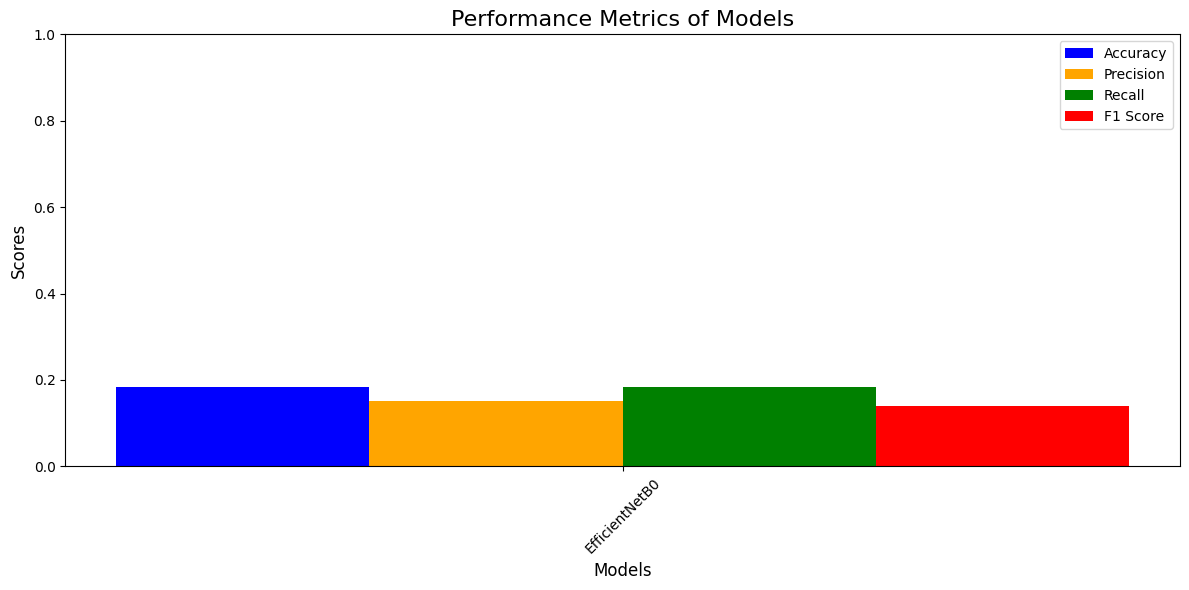

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Extract metrics for plotting
model_names = list(metrices.keys())
accuracies = [metrices[model]["accuracy"] for model in model_names]
precisions = [metrices[model]["precision"] for model in model_names]
recalls = [metrices[model]["recall"] for model in model_names]
f1_scores = [metrices[model]["f1"] for model in model_names]

# Define bar width and x positions
bar_width = 0.2
x = np.arange(len(model_names))

# Create the bar plots
plt.figure(figsize=(12, 6))

plt.bar(x - 1.5 * bar_width, accuracies, width=bar_width, label='Accuracy', color='blue')
plt.bar(x - 0.5 * bar_width, precisions, width=bar_width, label='Precision', color='orange')
plt.bar(x + 0.5 * bar_width, recalls, width=bar_width, label='Recall', color='green')
plt.bar(x + 1.5 * bar_width, f1_scores, width=bar_width, label='F1 Score', color='red')

# Add labels and titles
plt.xlabel('Models', fontsize=12)
plt.ylabel('Scores', fontsize=12)
plt.title('Performance Metrics of Models', fontsize=16)
plt.xticks(x, model_names, rotation=45, fontsize=10)
plt.ylim(0, 1)  # Metrics are typically between 0 and 1
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


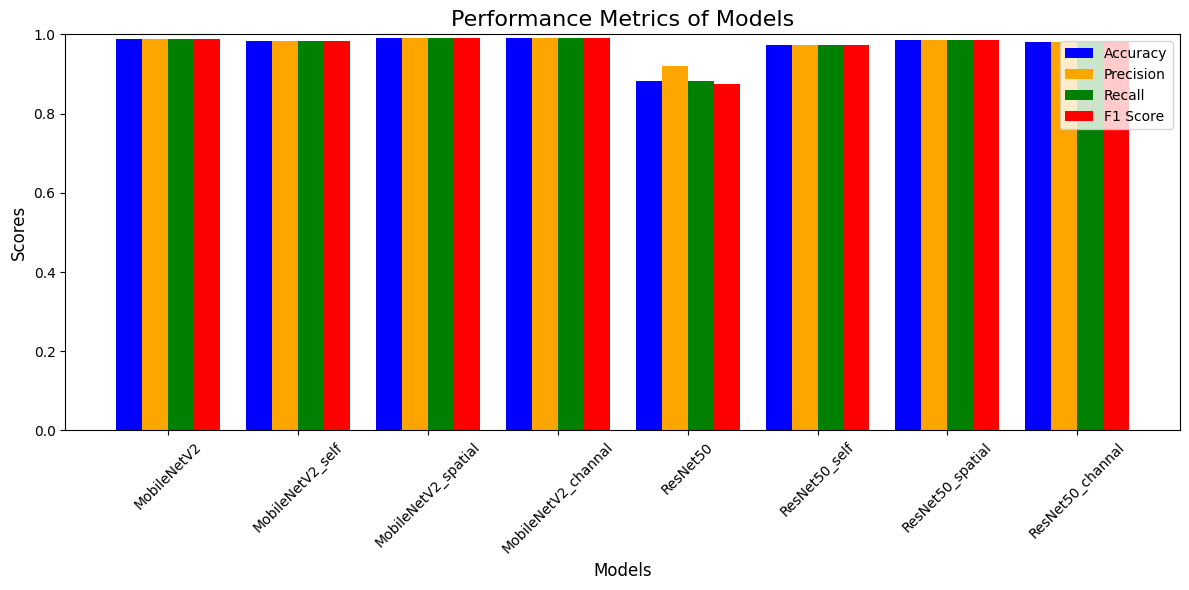

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Extract metrics for plotting
model_names = list(metrices.keys())
accuracies = [metrices[model]["accuracy"] for model in model_names]
precisions = [metrices[model]["precision"] for model in model_names]
recalls = [metrices[model]["recall"] for model in model_names]
f1_scores = [metrices[model]["f1"] for model in model_names]

# Define bar width and x positions
bar_width = 0.2
x = np.arange(len(model_names))

# Create the bar plots
plt.figure(figsize=(12, 6))

plt.bar(x - 1.5 * bar_width, accuracies, width=bar_width, label='Accuracy', color='blue')
plt.bar(x - 0.5 * bar_width, precisions, width=bar_width, label='Precision', color='orange')
plt.bar(x + 0.5 * bar_width, recalls, width=bar_width, label='Recall', color='green')
plt.bar(x + 1.5 * bar_width, f1_scores, width=bar_width, label='F1 Score', color='red')

# Add labels and titles
plt.xlabel('Models', fontsize=12)
plt.ylabel('Scores', fontsize=12)
plt.title('Performance Metrics of Models', fontsize=16)
plt.xticks(x, model_names, rotation=45, fontsize=10)
plt.ylim(0, 1)  # Metrics are typically between 0 and 1
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


235/235 ━━━━━━━━━━━━━━━━━━━━ 144s 613ms/step
Confusion Matrix for MobileNetV2


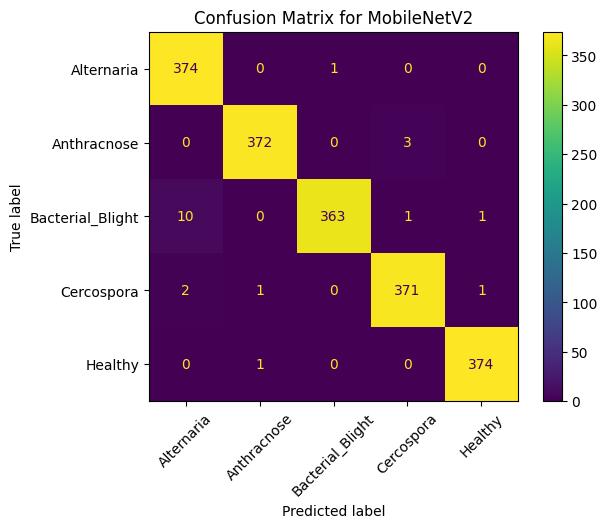

235/235 ━━━━━━━━━━━━━━━━━━━━ 129s 547ms/step
Confusion Matrix for MobileNetV2_self


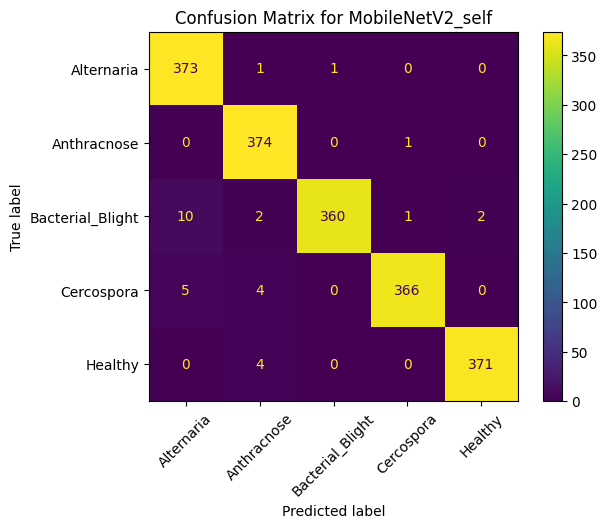

235/235 ━━━━━━━━━━━━━━━━━━━━ 131s 557ms/step
Confusion Matrix for MobileNetV2_spatial


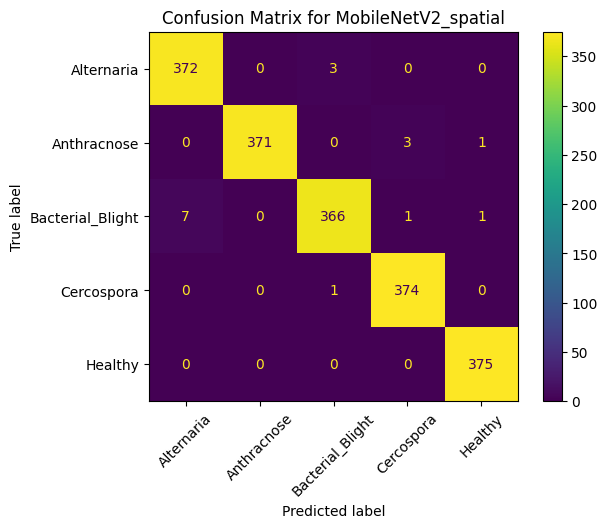

235/235 ━━━━━━━━━━━━━━━━━━━━ 146s 623ms/step
Confusion Matrix for MobileNetV2_channal


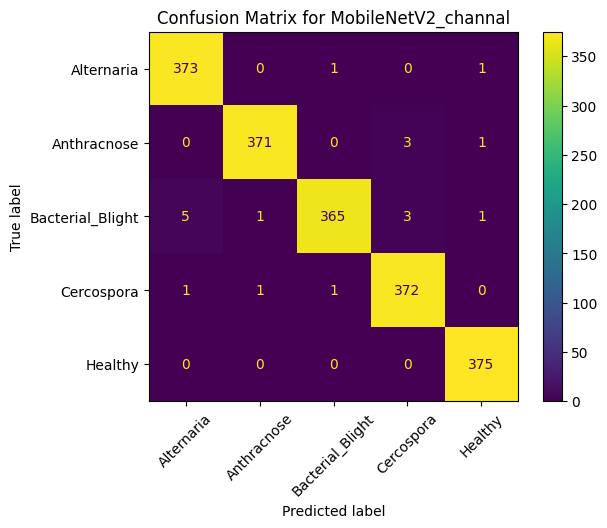

235/235 ━━━━━━━━━━━━━━━━━━━━ 142s 602ms/step
Confusion Matrix for ResNet50


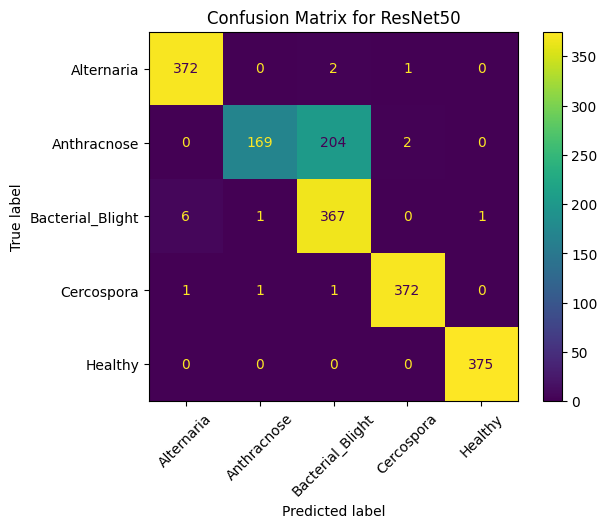

235/235 ━━━━━━━━━━━━━━━━━━━━ 147s 626ms/step
Confusion Matrix for ResNet50_self


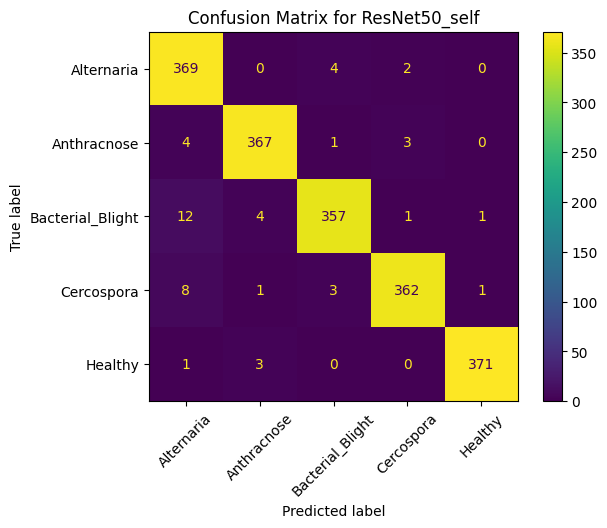

235/235 ━━━━━━━━━━━━━━━━━━━━ 148s 630ms/step
Confusion Matrix for ResNet50_spatial


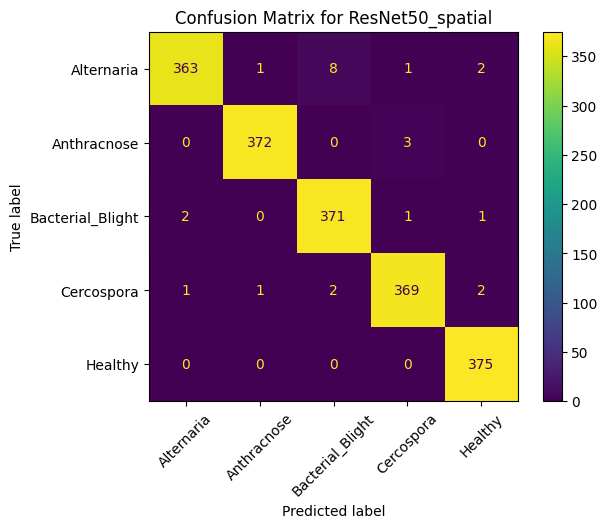

235/235 ━━━━━━━━━━━━━━━━━━━━ 149s 632ms/step
Confusion Matrix for ResNet50_channal


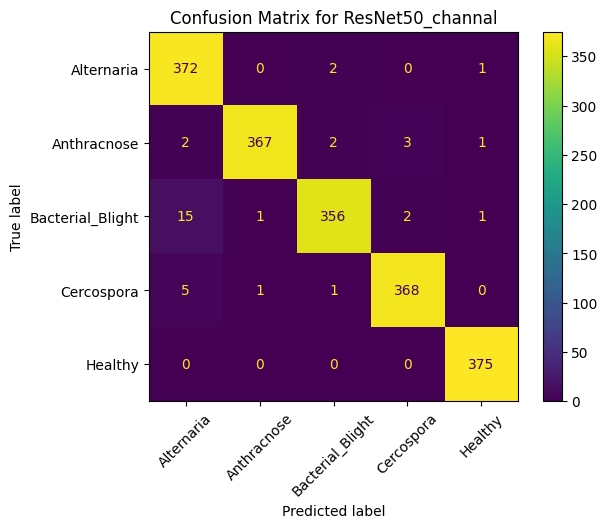

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Function to plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names, model_name):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='viridis', xticks_rotation=45)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

# Class names from the test dataset
class_names = list(test_dataset.class_indices.keys())

# Loop to compute and display the confusion matrix for each model
for model, name in zip(models, model_names):
    # Get predictions
    predictions = model.predict(test_dataset)
    predicted_classes = np.argmax(predictions, axis=1)

    # Plot the confusion matrix
    print(f'Confusion Matrix for {name}')
    plot_confusion_matrix(true_labels, predicted_classes, class_names, name)


In [ ]:
# from tensorflow.keras.models import load_model

# # Load the saved model
# model = load_model('/content/drive/MyDrive/Citrus/Pomegranate diseases dataset/mobilenet_spatial_model.h5')

# # Print model summary
# model.summary()

from tensorflow.keras.models import load_model
from tensorflow.keras.utils import custom_object_scope

# ... (Your other imports and code) ...

# Register custom layers
custom_objects = {
    "SelfAttention": SelfAttention,
    "ChannelAttention": ChannelAttention,
    "SpatialAttention": SpatialAttention
}

# Load models with custom layers
with custom_object_scope(custom_objects):
    model = load_model('/content/drive/MyDrive/Citrus/Pomegranate diseases dataset/mobilenet_spatial_model.h5')

# Print model summary
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_attention (SpatialAttention) │ (None, 7, 7, 1280)          │              99 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 1280)                │           5,120 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 224)                 │         286,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 224)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 5)                   │           1,125 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,551,274 (9.73 MB)

 Trainable params: 2,514,600 (9.59 MB)

 Non-trainable params: 36,672 (143.25 KB)

 Optimizer params: 2 (12.00 B)